In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import pickle
from glob import glob
import os
from keras.preprocessing.image import load_img

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset

from model import UNetResNet34, predict_proba
from utils import load_checkpoint
from dataset import pad_reflect, unpad_reflect, TgsDataSet
from postprocess import rle_encode

from importlib import reload
import metrics
reload(metrics)
from metrics import *

from augmentation_huang import do_center_pad_to_factor

In [5]:
from matplotlib import pyplot as plt

%matplotlib inline

## post-process

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#device = torch.device("cpu")
#torch.set_num_threads(20)

img_size_target = 128

SEED = 1234

In [7]:
# choose best threshold using validset
with open('../data/processed/dataset_%d.pkl'%SEED, 'rb') as f:
    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = pickle.load(f)

## select best_threshold for iou using valid dataset

In [8]:
# valid data & its flipped version
val_ds = TgsDataSet(x_valid, y_valid, transform=False)
val_dl = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

## x.shape = [1, 128, 128]
val_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_valid]), y_valid, transform=False)
val_dl_flip = DataLoader(
    val_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [9]:
# load the trained model
net = UNetResNet34(pretrained=True).cuda(device=device)
checkpoint_path = 'checkpoint/seed1234-hypercol-0839/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

In [10]:
preds_valid = (predict_proba(net, val_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, val_dl_flip, device)])) / 2

In [11]:
y_valid.shape, preds_valid.shape

((400, 1, 101, 101), (400, 128, 128))

In [12]:
# keep only nonzero mask images
preds_valid = preds_valid[y_valid.reshape(400, 101*101).sum(axis=1)!=0, :, :]
y_valid = y_valid[y_valid.reshape(400, 101*101).sum(axis=1)!=0, :, :, :]

In [16]:
thresholds = np.log(thresholds_ori/(1-thresholds_ori))
thresholds

array([-2.19722458, -1.93075834, -1.70869287, -1.51634749, -1.34513629,
       -1.18958407, -1.04596856, -0.91162872, -0.78458139, -0.66329422,
       -0.54654371, -0.43332206, -0.32277339, -0.21414799, -0.10676798,
        0.        ,  0.10676798,  0.21414799,  0.32277339,  0.43332206,
        0.54654371,  0.66329422,  0.78458139,  0.91162872,  1.04596856,
        1.18958407,  1.34513629,  1.51634749,  1.70869287,  1.93075834,
        2.19722458])


[0.77663934 0.78032787 0.78442623 0.78770492 0.78934426 0.79016393
 0.79098361 0.79221311 0.79303279 0.79344262 0.7942623  0.79385246
 0.7942623  0.7942623  0.79262295 0.79221311 0.79508197 0.78893443
 0.78729508 0.78811475 0.78852459 0.78770492 0.78729508 0.78729508
 0.78401639 0.78319672 0.77827869 0.77581967 0.7692623  0.76434426
 0.75901639]


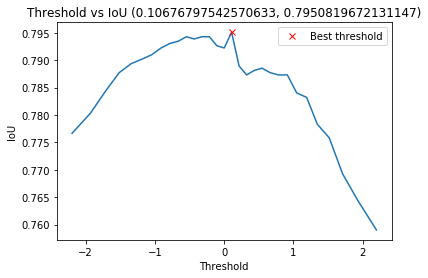

In [13]:
thresholds_ori = np.linspace(0.1, 0.9, 31)#np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori))

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)

y_valid = np.array([do_center_pad_to_factor(image.reshape(101, 101), factor=32).reshape(1, 128, 128) \
                    for image in y_valid]) #if use Huang's augmentation, otherwise comment this line
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [14]:
threshold_best, iou_best

(0.10676797542570633, 0.7950819672131147)

## using best threshold to predict

In [15]:
## create testset
img_ids = [f.split('/')[-1].split('.')[0] for f in glob('../data/raw/test_images/images/*.png')]

x_test = [(np.array(load_img("../data/raw/test_images/images/{}.png".format(idx), \
                                      color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(img_ids)]

In [81]:
# with open('../data/processed/testset%d.pkl'%SEED, 'wb') as f:
#     pickle.dump([img_ids, x_test], f)

In [16]:
# for testset, also predict raw & flipped version, then average
#x_test_arr = np.array(list(map(pad_reflect, x_test)))
x_test_arr = np.array(x_test).reshape(18000, 1, 101, 101) #if use Huang's augmentation, otherwise comment this line
y_test = np.zeros(shape=(18000, 1, 101, 101))

test_ds = TgsDataSet(x_test_arr, y_test, transform=False)
test_dl = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

test_ds_flip = TgsDataSet(np.array([x[:,:,::-1] for x in x_test_arr]), y_test, transform=False)
test_dl_flip = DataLoader(
    test_ds_flip,
    batch_size=32,
    shuffle=False,
    #sampler=StratifiedSampler(),
    num_workers=20,
)

In [17]:
%%time

#preds_test = predict_proba(net, test_dl, device)

preds_test = (predict_proba(net, test_dl, device) + \
              np.array([x[:,::-1] for x in predict_proba(net, test_dl_flip, device)])) / 2

CPU times: user 43min 41s, sys: 19min 28s, total: 1h 3min 10s
Wall time: 3min 18s


In [18]:
## pred_prob to preds by threashold_best, and unpad to 101x101
unpad_pred_dict = {idx: np.round(unpad_reflect(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(img_ids))}


In [19]:
# load saved predicted zero image ids, and remove small masks (<25)
# with open('../data/processed/zero_nonzero_img_ids.pkl', 'rb') as f:
#     zero_img_ids, nonzero_img_ids = pickle.load(f)

df = pd.read_csv('../submissions/013_0929_pytorch_pred_zero_mask.csv.gz')
zero_mask_ids = df.loc[df.rle_mask.notna(), 'id'].tolist()
print('another model predict zero mask in testset cnt: ', len(zero_mask_ids))

for k,v in unpad_pred_dict.items():
    if k in zero_mask_ids:#remove zero mask predictions
        v = v * 0
        unpad_pred_dict[k] = v
    else:
        continue

another model predict zero mask in testset cnt:  7886


In [52]:
# # predict zero, nonzero imgs
# zero_img_ids, nonzero_img_ids = [], []

# for k,v in unpad_pred_dict.items():
#     if v.sum()<25:
#         zero_img_ids.append(k)
#     else:
#         nonzero_img_ids.append(k)

# with open('../data/processed/zero_nonzero_img_ids.pkl', 'wb') as f:
#     pickle.dump(zero_mask_ids, f)

In [45]:
# cnt = 0
# for k,v in unpad_pred_dict.items():
#     if 0<v.sum()<25:
#         #print(k)
#         cnt += 1
# print(cnt)

# for k,v in unpad_pred_dict.items():
#     if v.sum()<25:
#         v *= 0
#         v[0, 0] = 1
#         unpad_pred_dict[k] = v
#     else:
#         v *= 0
#         unpad_pred_dict[k] = v

In [43]:
print('pred zero mask: ', 7848, 7848/18000)

pred zero mask:  7848 0.436


In [20]:
## for single model submission
pred_dict = {idx: rle_encode(pred) for idx, pred in tqdm_notebook(unpad_pred_dict.items())}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

In [22]:
#print(sub_name)
sub.to_csv('../submissions/1002_pytorch_clfzero_hypercol_check_839model.csv.gz', compression='gzip', index=False)

## blending models

In [ ]:
## TODO: for 5-fold-cv models, blend probability preds here (Note each model has specific threshold_best)
pred = []

In [ ]:
_pred = np.round(preds_test > threshold_best)
pred.append(_pred)

In [ ]:
preds_test_blend = np.round((pred[0] + pred[1] + pred[2]) / 3 > 0.5)

In [ ]:
# convert to rle_mask format and submit
pred_dict = {idx: rle_encode(downsample(preds_test_blend[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

In [ ]:
sub.to_csv('submissions/0910_unet080_seed_epoch100_3fold_blend.csv.gz', compression='gzip', index=False)

In [ ]:
sub